In [1]:
import os
import pandas as pd
import numpy as np
import datetime
import math
import empyrical as empy
from sklearn.metrics import precision_score, accuracy_score, confusion_matrix, mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import warnings
warnings.filterwarnings("ignore")

In [2]:
def drawdown_from_price(price):
    if isinstance(price, pd.Series):
        return _drawdown_from_price(price)
    elif isinstance(price, pd.DataFrame):
        return price.apply(_drawdown_from_price)
    else:
        raise non_pd_error

def _drawdown_from_price(price):
    shift_max = price.copy()
    _max = price.iloc[0]
    for i, j in price.items():
        #print('i', i)
        #print('j', j)
        _max = max(_max, j)
        shift_max[i] = _max
    return price / shift_max - 1

def return_to_price(ret, ini=100):
    price_0 = ret.iloc[:1] * 0 + ini
    price_0.index = [0]
    price = (1+ret).cumprod() * ini
    return pd.concat([price_0, price])

def drawdown_from_return(ret, ini=100):
    price = return_to_price(ret, ini)
    return drawdown_from_price(price).iloc[1:]

def avg_drawdown(ret):
    dd = drawdown_from_return(ret)
    return dd.mean()


def other_metric(ret, true_up=None, true_ret=None):
    if isinstance(ret, pd.DataFrame):
        return ret.apply(other_metric, true_up=true_up, true_ret=true_ret).T
    se = pd.Series(dtype='float64')
    pred_up = (ret!=0)*1
    highlight_ratio = pred_up.mean()
    flip_ratio = (pred_up - pred_up.shift()).abs().mean()

    se['buy_ratio'] = highlight_ratio
    se['flip_ratio'] = flip_ratio
    
    if true_up is not None and true_ret is not None:
        idx_tmp = pred_up.index & true_up.index
        true_up_tmp = true_up.reindex(idx_tmp) * 1
        pred_up = pred_up.reindex(idx_tmp) * 1

        accu = accuracy_score(true_up_tmp, pred_up)
        prec = precision_score(true_up_tmp, pred_up)
        
        true_up_pct = true_ret.reindex(idx_tmp)
        true_up_pct_scaled = true_up_pct/true_up_pct.std() + 0.5
        
        mse = mean_squared_error(true_up_pct_scaled, pred_up)

        se['accu'] = accu
        se['prec'] = prec
        se['mse'] = mse
    
    return se


def empy_metric(ret):
    if isinstance(ret, pd.DataFrame):
        return ret.apply(empy_metric).T
    total_return = lambda x: (1+x).prod()-1
    met_func = [total_return, empy.annual_return, empy.sharpe_ratio, empy.annual_volatility, 
                empy.max_drawdown, avg_drawdown]
    
    met_func_names = ['total_return', 'annual_return', 'sharpe_ratio', 'annual_volatility', 
                      'max_drawdown', 'avg_drawdown',]
    
    se = pd.Series([f(ret) for f in met_func], met_func_names)
    
    se['return/maxdd'] = -se.annual_return/se.max_drawdown
    se['return/avgdd'] = -se.annual_return/se.avg_drawdown
    
    return se

client_weight_agg = {'sharpe_ratio':5,'annual_return':5, 'max_drawdown':5}
client_weight_agg2 = {'sharpe_ratio':5,'annual_return':5, 'max_drawdown':5, 'avg_drawdown':5}
def calculation_score(df, client_weight=client_weight_agg, client_weight2=client_weight_agg2):
    df['Sharpe Score'] = df['sharpe_ratio'].apply(lambda x: x if x>0 else 0) * 100
    df['Return Score'] = df['annual_return'].apply(lambda x: 1+x/2) * 100
    df['Max-DD Score'] = df['max_drawdown'].apply(lambda x: 1+x) * 100
    df['Avg-DD Score'] = df['avg_drawdown'].apply(lambda x: 1+x) * 100

    df['Total Score'] = 0
    for score, weight in client_weight.items():
        df['Total Score'] += weight * df[score]

    df['Total Score2'] = 0
    for score, weight in client_weight2.items():
        df['Total Score2'] += weight * df[score]
    df.index.name = 'case'
    return df


def show_cum_ret(ret_df):
    fig, ax = plt.subplots(figsize=(20,15))
    
    cm = plt.get_cmap('gist_rainbow')
    NUM_COLORS = ret_df.shape[1]
    ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])


    (1+ret_df).cumprod().plot(ax=ax)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_yscale("log")
    plt.show()


def print_all_result(ret_df, true_up, true_ret, proba_df=None, topn=10, strategy_list_sel=None, base_case=None):
    
    display('{} to {}'.format(ret_df.index[0], ret_df.index[-1]))
    column_selected = ['total_return', 'annual_return', 'sharpe_ratio', 'max_drawdown', 'avg_drawdown', 'return/avgdd',]
    empy_metric_tmp = empy_metric(ret_df).sort_values('sharpe_ratio')
    # print(empy_metric_tmp.loc[['buy_and_hold']])
    if strategy_list_sel is None:
        empy_metric_tmp = empy_metric(ret_df).sort_values('sharpe_ratio')
        if isinstance(topn, int):
            strategy_list_sel = list(empy_metric_tmp.index)
            strategy_list_sel = strategy_list_sel[-topn:]
        else:
            strategy_list_sel = list(empy_metric_tmp.loc[topn:].index)
    else:
        if base_case is not None:
            usecols = list(set(strategy_list_sel + base_case))
        else:
            usecols = strategy_list_sel
        empy_metric_tmp = empy_metric(ret_df[usecols]).sort_values('sharpe_ratio')

    # if ('buy_and_hold') in strategy_list_sel:
    #     strategy_list_sel = [x for x in strategy_list_sel if x !='buy_and_hold']
    
    base_list = []
    if (base_case is not None) and (len(base_case) > 0):
        base_list = list(empy_metric_tmp.loc[base_case, :].index)
        for bc in base_list:
            if bc in strategy_list_sel:
                strategy_list_sel.remove(bc)

    strategy_list_sel = base_list + strategy_list_sel
    other_metric_tmp = other_metric(ret_df[strategy_list_sel], true_up, true_ret)
    
    display(other_metric_tmp.loc[strategy_list_sel[1:]].iloc[:,:5])
    display(empy_metric_tmp.loc[strategy_list_sel][column_selected])
    
    plot_cum_return(ret_df[strategy_list_sel])
    
#     cvals  = [0, 0.5, 1]
#     colors = ["red", 'white', "lawngreen"]
#     cmap = LinearSegmentedColormap.from_list("", colors)
#     norm=plt.Normalize(min(cvals),max(cvals))
#     tuples = list(zip(map(norm,cvals), colors))
#     cmap = LinearSegmentedColormap.from_list("", tuples)
#     sm = plt.cm.ScalarMappable(cmap=cmap)#, norm=norm
#     sm.set_array([])

    
    if proba_df is None:
        return strategy_list_sel

    alpha = 1
    dot_size = 20
    
    base_cumret = (1+ret_df[base_case]).cumprod().apply(math.log)
    base_cumret.name = 'buy_and_hold'
    
    for case in strategy_list_sel:
        if case not in proba_df.columns:
            continue
        print("====================================", case)
#         try:
        if True:
            df_temp = pd.concat([ret_df[case], proba_df[case]],1,keys=['return','pred prob']).dropna()

    #         df_temp['log return'] = (1+df_temp['return']).apply(math.log)
    #         df_temp['cumulative return'] = (1+df_temp['return']).cumprod()-1
            df_temp['log cumulative return'] = (1+df_temp['return']).cumprod().apply(math.log)

            z_ret = ret_df[case]/ret_df[case].std()
            z_prod = (proba_df[case]-0.5)/proba_df[case].std()
            df_temp['score'] = 3-abs(z_ret-z_prod)

            df_temp = df_temp.reset_index()
            df_temp['date'] = pd.to_datetime(df_temp['date'])
            
#             display(df_temp)
            
            plot_hue = 'pred prob'
        
            cvals  = [0,0.5,1]
            colors = ["red","white","lawngreen"]
            norm = plt.Normalize(min(cvals),max(cvals))
            tuples = list(zip(map(norm,cvals), colors))
            cmap_prob = LinearSegmentedColormap.from_list("", tuples)
            sm_prob = plt.cm.ScalarMappable(cmap=cmap_prob, norm=norm)
            sm_prob.set_array([])
            
            fig, ax = plt.subplots(figsize=(20,15))
            ax = sns.scatterplot(data=df_temp, x='date', y='log cumulative return', hue=plot_hue,
                                 #hue='score', alpha=0.5, palette=cmap, s=20)
                                 alpha=0.5, palette=cmap_prob, s=dot_size
#                                  cmap=cmap_prob
                                )
            base_cumret.plot(ax=ax)

            ax.set_xlim([df_temp['date'].iloc[0], df_temp['date'].iloc[-1]])
            ax.get_legend()#.remove()
#             ax.set_yscale("log")
            ax.figure.colorbar(sm_prob)
            ax.set_title("{} {}".format(case, plot_hue))
            plt.show()
            
#             fig, ax = plt.subplots(figsize=(12,10))
#             proba_df.loc[ret_df.index, case].plot(kind='bar', ax=ax, legend=False)
# #             ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#             ax.set_title(case + ' proba')
#             plt.show()
#         except Exception as e:
#             print(e)
#             continue
    
    
    return strategy_list_sel

# long history

In [3]:
base_folder = './result/2022/cashON_signal/result/combine_all/withAssetSliding_longhistory'

In [4]:
all_ret = {}
all_met = {}
if True:
    case_folder = base_folder
    for f in os.listdir(case_folder):
        try:
            case_type2 = f.split('_')
            if len(case_type2) > 2:
                case_type2 = [case_type2[0], "_".join(case_type2[1:])]
            # case_type2 = [sliding_case_name] + case_type2
            # if len(case_type2) > 2:
            #     case_type2 = [case_type2[0], "_".join(case_type2[1:])]
            print(case_type2)

            ret = pd.read_csv(os.path.join(case_folder, f, 'final_ret.csv'), index_col=0)
            names = ['case_metrics', 'case_combine']
            ret.columns = pd.MultiIndex.from_tuples([idx.rsplit("_", 1) if idx != "no_3vote" else ["", "no_3vote"] for idx in ret.columns], names=names)
            ret.index = pd.to_datetime(ret.index)
            all_ret[tuple(case_type2)] = ret
            met = pd.read_csv(os.path.join(case_folder, f, 'final_metrics.csv'), index_col=0)
            names = ['case_metrics', 'case_combine']
            met.index = pd.MultiIndex.from_tuples([idx.rsplit("_", 1) if idx != "no_3vote" else ["", "no_3vote"] for idx in met.index], names=names)
            all_met[tuple(case_type2)] = met
        except Exception as e:
            print("Failed for {}".format(f))
            print(e)
    # break
all_ret_df = pd.concat(all_ret.values(), keys=all_ret.keys(), axis=1)

['met(from1988).csv']
Failed for met(from1988).csv
[Errno 2] No such file or directory: './result/2022/cashON_signal/result/combine_all/withAssetSliding_longhistory\\met(from1988).csv\\final_ret.csv'
['met(from1997).csv']
Failed for met(from1997).csv
[Errno 2] No such file or directory: './result/2022/cashON_signal/result/combine_all/withAssetSliding_longhistory\\met(from1997).csv\\final_ret.csv'
['met(from2008).csv']
Failed for met(from2008).csv
[Errno 2] No such file or directory: './result/2022/cashON_signal/result/combine_all/withAssetSliding_longhistory\\met(from2008).csv\\final_ret.csv'
['met(from2013).csv']
Failed for met(from2013).csv
[Errno 2] No such file or directory: './result/2022/cashON_signal/result/combine_all/withAssetSliding_longhistory\\met(from2013).csv\\final_ret.csv'
['met(from2016).csv']
Failed for met(from2016).csv
[Errno 2] No such file or directory: './result/2022/cashON_signal/result/combine_all/withAssetSliding_longhistory\\met(from2016).csv\\final_ret.csv'


In [5]:
# 13ETFs	v1	sliding1Y	2thresholds	combine2	no_3vote
idx_names = ['sliding_year', 'case_pool', 'case_metrics', 'case_combine']
all_ret_df.columns.names = idx_names

In [6]:
start = '1997'
all_met_df = empy_metric(all_ret_df[start:].dropna())
all_met_df = calculation_score(all_met_df)
all_met_df = pd.concat([all_met_df, other_metric(all_ret_df[start:].dropna())], axis=1)
# all_met_df_dict[sliding_case_name] = all_met_df

In [7]:
all_met_df.to_csv(os.path.join(base_folder, 'met(from{}).csv'.format(start)))

In [8]:
base_case_name = 'no_3vote'
base_case_ret = all_ret_df.loc[:, all_ret_df.columns.get_level_values('case_combine') == base_case_name].iloc[:, [0]]
base_case_ret.columns = pd.MultiIndex.from_tuples([("", "", "", base_case_name)], names=idx_names)
# display(base_case_ret)
base_case_met = all_met_df.loc[all_met_df.index.get_level_values('case_combine') == base_case_name, :].iloc[[0], :]
base_case_met.index = pd.MultiIndex.from_tuples([("", "", "", base_case_name)], names=idx_names)
base_case_met

,,,,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
sliding_year,case_pool,case_metrics,case_combine,,,,,,,,,,,,,,,,
,,,no_3vote,9.175958,0.092493,0.783879,0.122444,-0.299392,-0.074685,0.308936,1.238445,78.387882,104.624651,70.060753,92.53152,2.884897,2.511473,0.988501,0.0227


In [9]:
sort_by = 'sharpe_ratio'
sort_df = all_met_df.sort_values(sort_by, ascending=False)
show_df = sort_df[sort_df[sort_by] > base_case_met[sort_by].values[0]]
show_df = pd.concat([base_case_met, show_df])
# show_df.head(20)

In [10]:
sort_df.loc[sort_df.index.get_level_values('case_combine') != base_case_name, :]

total_return  \
sliding_year                       case_pool case_metrics case_combine                 
sliding2Y                          CorrVol   sharpe_ratio combine1          7.649684   
                                             Total Score  combine1          7.767555   
                                             Total Score2 combine1          7.595501   
sliding8Y                          CorrVol   Total Score  combine1          7.054443   
                                             Total Score2 combine1          6.702376   
                                             sharpe_ratio combine1          6.651062   
sliding9Y                          CorrVol   Total Score  combine1          6.513259   
                                             Total Score2 combine1          6.319787   
                                             sharpe_ratio combine1          6.170942   
sliding6Y                          CorrVol   sharpe_ratio combine1          6.043160   
sliding7Y                          CorrVol   sharpe_ratio combine1          5.236017   
                                             Total Score  combine1          5.288758   
                                             Total Score2 combine1          5.288758   
sliding6Y                          CorrVol   Total Score  combine1          5.093938   
                                             Total Score2 combine1          5.031338   
sliding4Y                          CorrVol   Total Score2 combine1          4.436147   
sliding5Y                          CorrVol   sharpe_ratio combine1          4.603664   
sliding10Y                         CorrVol   sharpe_ratio combine1          4.547485   
                                             Total Score  combine1          4.498357   
                                             Total Score2 combine1          4.498357   
performanceSlidingYearInclude5-8Y  CorrVol   sharpe_ratio combine1          4.556156   
performanceSlidingYearInclude3-8Y  CorrVol   Total Score  combine1          4.552231   
                                             Total Score2 combine1          4.552231   
sliding4Y                          CorrVol   Total Score  combine1          4.178164   
performanceSlidingYearExclude1&2Y  CorrVol   Total Score  combine1          4.415894   
performanceSlidingYearInclude5-8Y  CorrVol   Total Score2 combine1          4.374853   
                                             Total Score  combine1          4.374853   
performanceSlidingYearExclude1&2Y  CorrVol   Total Score2 combine1          4.316560   
sliding5Y                          CorrVol   Total Score2 combine1          4.175914   
                                             Total Score  combine1          4.121483   
sliding4Y                          CorrVol   sharpe_ratio combine1          3.886395   
performanceSlidingYearExclude1&2Y  CorrVol   sharpe_ratio combine1          3.800463   
performanceSlidingYearInclude3-8Y  CorrVol   sharpe_ratio combine1          3.851731   
performanceSlidingYearInclude3-10Y CorrVol   Total Score2 combine1          3.698145   
                                             Total Score  combine1          3.417203   
performanceSlidingYearInclude5-10Y CorrVol   sharpe_ratio combine1          3.148463   
performanceSlidingYearInclude3-10Y CorrVol   sharpe_ratio combine1          2.951323   
performanceSlidingYearInclude5-10Y CorrVol   Total Score2 combine1          2.933981   
                                             Total Score  combine1          2.933981   
sliding3Y                          CorrVol   Total Score  combine1          2.859543   
                                             Total Score2 combine1          2.859543   
sliding1Y                          CorrVol   Total Score2 combine1          2.468333   
sliding3Y                          CorrVol   sharpe_ratio combine1          2.787394   
sliding1Y                          CorrVol   Total Score  combine1          2.293156   
                        

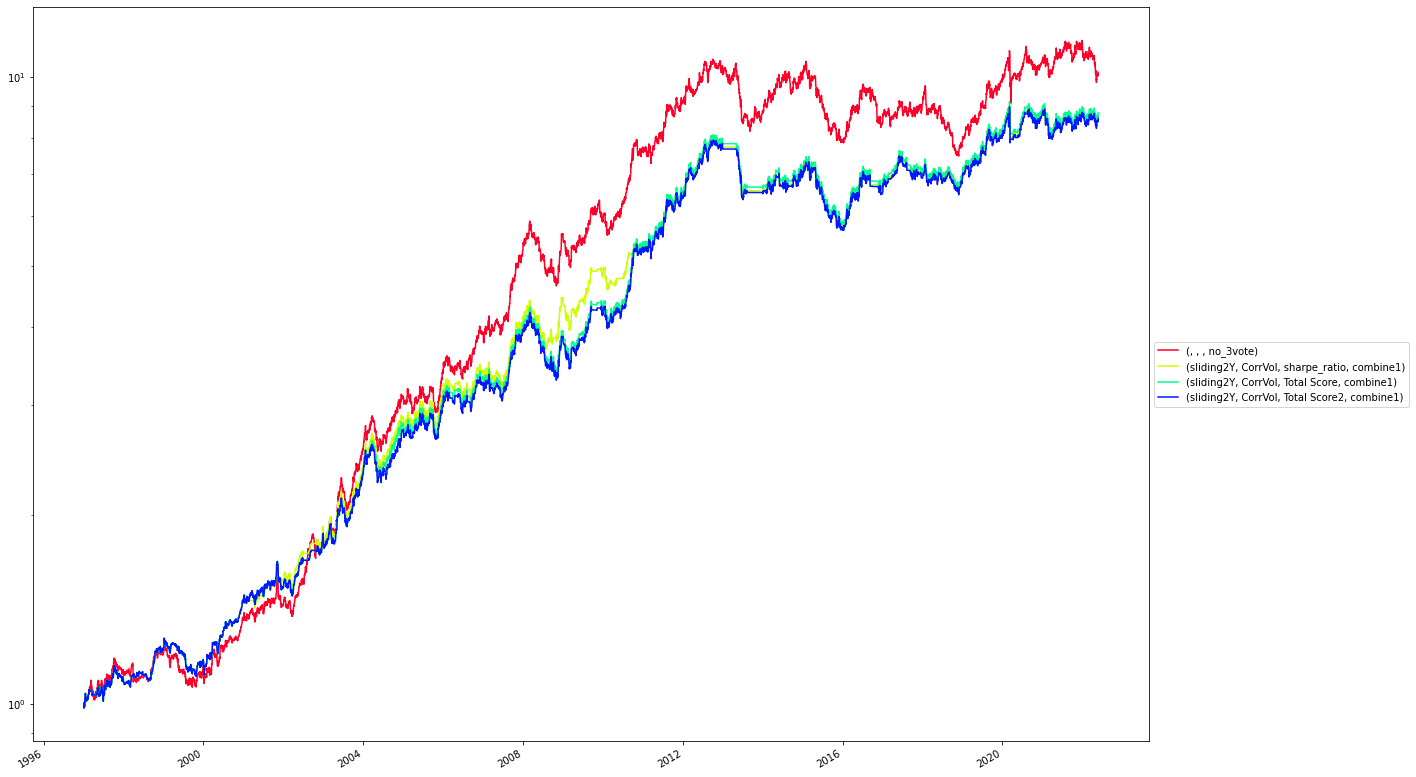

In [12]:
show_ret = pd.concat([base_case_ret, all_ret_df[show_df.index[1:10]]], axis=1)
show_ret = show_ret.dropna()
show_cum_ret(show_ret[start:])

In [13]:
start = '2008'
all_met_df = empy_metric(all_ret_df[start:].dropna())
all_met_df = calculation_score(all_met_df)
all_met_df = pd.concat([all_met_df, other_metric(all_ret_df[start:].dropna())], axis=1)
# all_met_df_dict[sliding_case_name] = all_met_df

all_met_df.to_csv(os.path.join(base_folder, 'met(from{}).csv'.format(start)))
base_case_name = 'no_3vote'
base_case_ret = all_ret_df.loc[:, all_ret_df.columns.get_level_values('case_combine') == base_case_name].iloc[:, [0]]
base_case_ret.columns = pd.MultiIndex.from_tuples([("", "", "", base_case_name)], names=idx_names)
# display(base_case_ret)
base_case_met = all_met_df.loc[all_met_df.index.get_level_values('case_combine') == base_case_name, :].iloc[[0], :]
base_case_met.index = pd.MultiIndex.from_tuples([("", "", "", base_case_name)], names=idx_names)
display(base_case_met)

sort_by = 'sharpe_ratio'
sort_df = all_met_df.sort_values(sort_by, ascending=False)
show_df = sort_df[sort_df[sort_by] > base_case_met[sort_by].values[0]]
show_df = pd.concat([base_case_met, show_df])
# display(show_df.head(20))

sort_df.loc[sort_df.index.get_level_values('case_combine') != base_case_name, :]

,,,,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
sliding_year,case_pool,case_metrics,case_combine,,,,,,,,,,,,,,,,
,,,no_3vote,0.922305,0.044944,0.411216,0.126342,-0.299392,-0.10195,0.150119,0.440847,41.121634,102.247225,70.060753,89.804974,0.783842,0.27409,0.988254,0.022964


total_return  \
sliding_year                       case_pool case_metrics case_combine                 
sliding2Y                          CorrVol   Total Score2 combine1          1.171265   
                                             Total Score  combine1          1.171265   
sliding8Y                          CorrVol   Total Score  combine1          1.241192   
sliding2Y                          CorrVol   sharpe_ratio combine1          1.088315   
sliding8Y                          CorrVol   Total Score2 combine1          1.143228   
                                             sharpe_ratio combine1          1.128950   
sliding9Y                          CorrVol   Total Score  combine1          0.865811   
                                             Total Score2 combine1          0.817765   
sliding6Y                          CorrVol   sharpe_ratio combine1          0.823199   
                                             Total Score  combine1          0.823199   
                                             Total Score2 combine1          0.804470   
sliding9Y                          CorrVol   sharpe_ratio combine1          0.772298   
sliding4Y                          CorrVol   Total Score2 combine1          0.710927   
performanceSlidingYearInclude5-8Y  CorrVol   Total Score  combine1          0.709112   
                                             Total Score2 combine1          0.709112   
sliding4Y                          CorrVol   Total Score  combine1          0.629732   
sliding5Y                          CorrVol   sharpe_ratio combine1          0.637622   
                                             Total Score2 combine1          0.625487   
                                             Total Score  combine1          0.625487   
performanceSlidingYearInclude5-8Y  CorrVol   sharpe_ratio combine1          0.627129   
performanceSlidingYearInclude3-8Y  CorrVol   Total Score2 combine1          0.585132   
                                             Total Score  combine1          0.585132   
sliding7Y                          CorrVol   sharpe_ratio combine1          0.565592   
sliding4Y                          CorrVol   sharpe_ratio combine1          0.537903   
performanceSlidingYearExclude1&2Y  CorrVol   Total Score  combine1          0.546209   
sliding7Y                          CorrVol   Total Score  combine1          0.522717   
                                             Total Score2 combine1          0.522717   
performanceSlidingYearExclude1&2Y  CorrVol   Total Score2 combine1          0.517849   
performanceSlidingYearInclude3-8Y  CorrVol   sharpe_ratio combine1          0.463900   
performanceSlidingYearExclude1&2Y  CorrVol   sharpe_ratio combine1          0.448431   
performanceSlidingYearInclude3-10Y CorrVol   Total Score2 combine1          0.341295   
sliding3Y                          CorrVol   sharpe_ratio combine1          0.317128   
sliding10Y                         CorrVol   sharpe_ratio combine1          0.267080   
sliding3Y                          CorrVol   Total Score  combine1          0.270009   
                                             Total Score2 combine1          0.270009   
performanceSlidingYearInclude3-10Y CorrVol   Total Score  combine1          0.261088   
sliding10Y                         CorrVol   Total Score  combine1          0.255859   
                                             Total Score2 combine1          0.255859   
performanceSlidingYearInclude5-10Y CorrVol   Total Score2 combine1          0.250939   
                                             Total Score  combine1          0.250939   
                                             sharpe_ratio combine1          0.214884   
performanceSlidingYearInclude3-10Y CorrVol   sharpe_ratio combine1          0.192222   
sliding1Y                          CorrVol   Total Score2 combine1          0.093653   
                                             sharpe_ratio combine1          0.038415   
                        

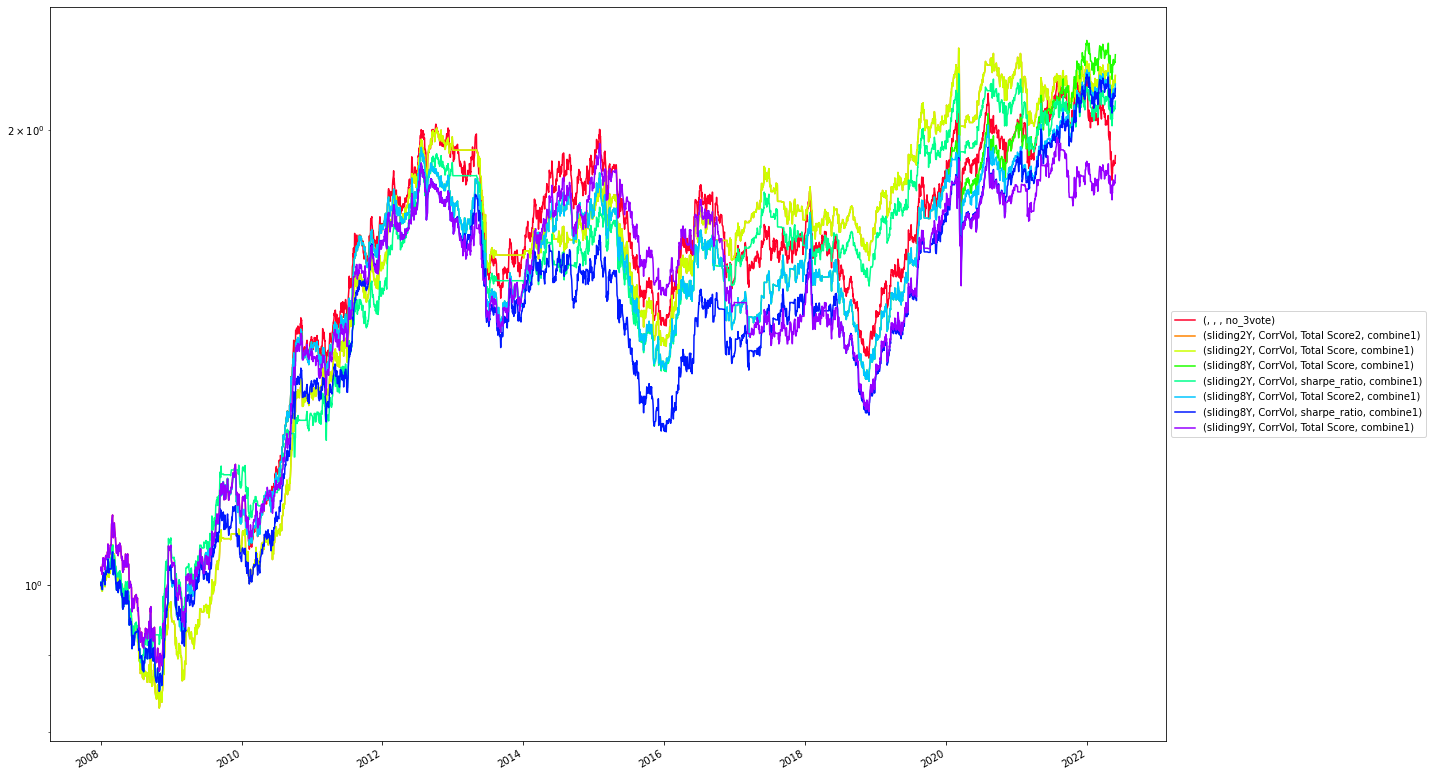

In [14]:
show_ret = pd.concat([base_case_ret, all_ret_df[show_df.index[1:10]]], axis=1)
show_ret = show_ret.dropna()
show_cum_ret(show_ret[start:])

In [15]:
start = '2013'
all_met_df = empy_metric(all_ret_df[start:].dropna())
all_met_df = calculation_score(all_met_df)
all_met_df = pd.concat([all_met_df, other_metric(all_ret_df[start:].dropna())], axis=1)
# all_met_df_dict[sliding_case_name] = all_met_df

all_met_df.to_csv(os.path.join(base_folder, 'met(from{}).csv'.format(start)))
base_case_name = 'no_3vote'
base_case_ret = all_ret_df.loc[:, all_ret_df.columns.get_level_values('case_combine') == base_case_name].iloc[:, [0]]
base_case_ret.columns = pd.MultiIndex.from_tuples([("", "", "", base_case_name)], names=idx_names)
# display(base_case_ret)
base_case_met = all_met_df.loc[all_met_df.index.get_level_values('case_combine') == base_case_name, :].iloc[[0], :]
base_case_met.index = pd.MultiIndex.from_tuples([("", "", "", base_case_name)], names=idx_names)
display(base_case_met)

sort_by = 'sharpe_ratio'
sort_df = all_met_df.sort_values(sort_by, ascending=False)
show_df = sort_df[sort_df[sort_by] > base_case_met[sort_by].values[0]]
show_df = pd.concat([base_case_met, show_df])
# display(show_df.head(20))

sort_df.loc[sort_df.index.get_level_values('case_combine') != base_case_name, :]

,,,,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
sliding_year,case_pool,case_metrics,case_combine,,,,,,,,,,,,,,,,
,,,no_3vote,-0.002925,-0.000302,0.060602,0.12573,-0.29378,-0.122329,-0.001028,-0.002468,6.060183,99.984906,70.621966,87.767086,-1.167402,-1.779048,0.987321,0.025368


total_return  \
sliding_year                       case_pool case_metrics case_combine                 
sliding8Y                          CorrVol   Total Score  combine1          0.267145   
                                             sharpe_ratio combine1          0.232479   
                                             Total Score2 combine1          0.211757   
sliding2Y                          CorrVol   sharpe_ratio combine1          0.120072   
                                             Total Score2 combine1          0.120072   
                                             Total Score  combine1          0.120072   
sliding9Y                          CorrVol   sharpe_ratio combine1          0.080485   
                                             Total Score  combine1          0.080485   
sliding6Y                          CorrVol   sharpe_ratio combine1          0.068633   
                                             Total Score  combine1          0.068633   
                                             Total Score2 combine1          0.057655   
sliding9Y                          CorrVol   Total Score2 combine1          0.052662   
performanceSlidingYearInclude5-8Y  CorrVol   Total Score2 combine1         -0.000332   
                                             Total Score  combine1         -0.000332   
sliding5Y                          CorrVol   sharpe_ratio combine1         -0.031770   
performanceSlidingYearExclude1&2Y  CorrVol   sharpe_ratio combine1         -0.040830   
sliding5Y                          CorrVol   Total Score  combine1         -0.042058   
                                             Total Score2 combine1         -0.042058   
sliding7Y                          CorrVol   sharpe_ratio combine1         -0.061024   
performanceSlidingYearExclude1&2Y  CorrVol   Total Score2 combine1         -0.075144   
                                             Total Score  combine1         -0.075144   
sliding4Y                          CorrVol   Total Score2 combine1         -0.070856   
performanceSlidingYearInclude5-8Y  CorrVol   sharpe_ratio combine1         -0.081498   
sliding7Y                          CorrVol   Total Score  combine1         -0.096875   
                                             Total Score2 combine1         -0.096875   
performanceSlidingYearInclude3-8Y  CorrVol   Total Score  combine1         -0.101067   
                                             Total Score2 combine1         -0.101067   
sliding4Y                          CorrVol   Total Score  combine1         -0.114950   
                                             sharpe_ratio combine1         -0.114950   
performanceSlidingYearInclude3-8Y  CorrVol   sharpe_ratio combine1         -0.131746   
sliding3Y                          CorrVol   sharpe_ratio combine1         -0.151566   
                                             Total Score  combine1         -0.181918   
                                             Total Score2 combine1         -0.181918   
sliding1Y                          CorrVol   Total Score2 combine1         -0.159933   
                                             Total Score  combine1         -0.202362   
                                             sharpe_ratio combine1         -0.202362   
performanceSlidingYearInclude3-10Y CorrVol   Total Score2 combine1         -0.238581   
sliding10Y                         CorrVol   sharpe_ratio combine1         -0.237478   
                                             Total Score2 combine1         -0.244231   
                                             Total Score  combine1         -0.244231   
performanceSlidingYearInclude5-10Y CorrVol   Total Score2 combine1         -0.258109   
                                             sharpe_ratio combine1         -0.258109   
                                             Total Score  combine1         -0.258109   
performanceSlidingYearInclude3-10Y CorrVol   Total Score  combine1         -0.284113   
                        

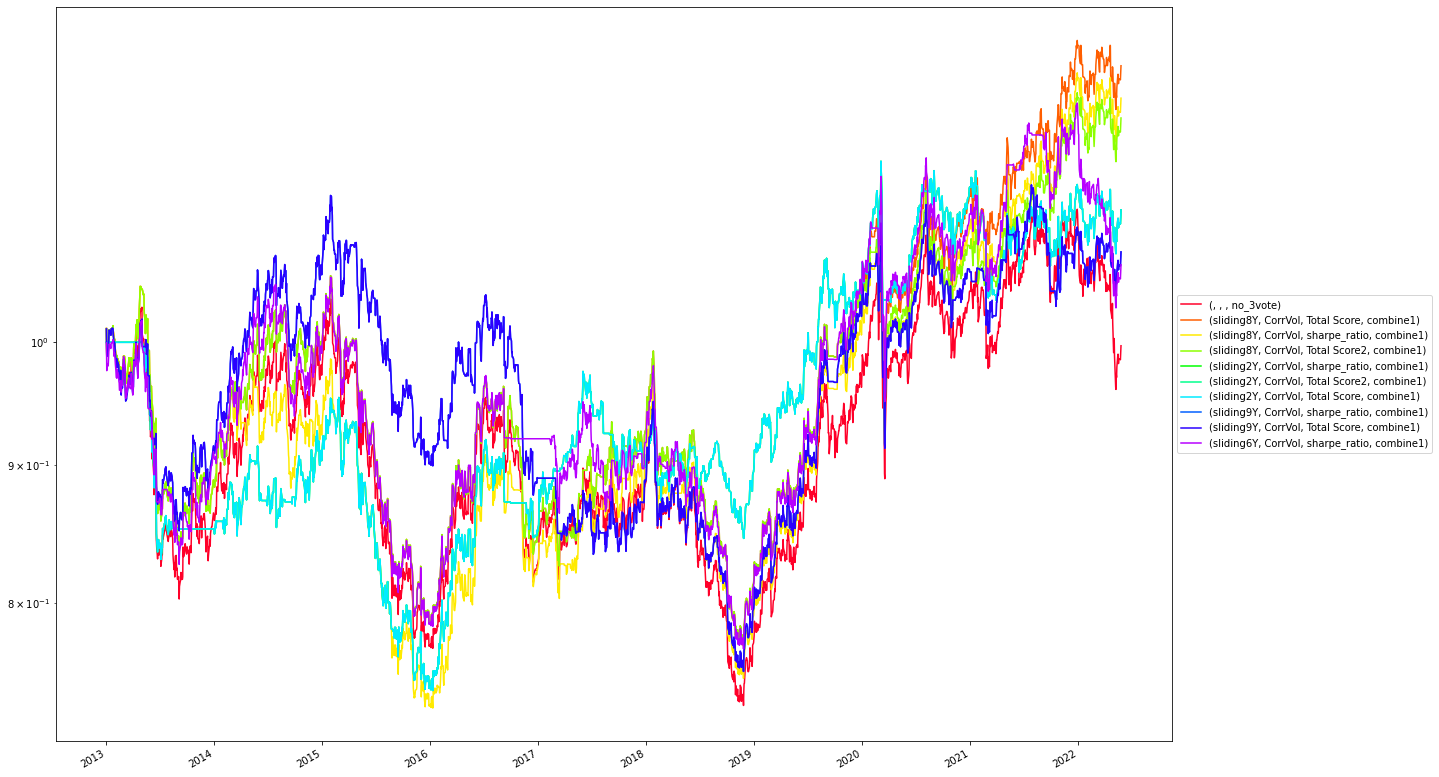

In [16]:
show_ret = pd.concat([base_case_ret, all_ret_df[show_df.index[1:10]]], axis=1)
show_ret = show_ret.dropna()
show_cum_ret(show_ret[start:])

In [17]:
start = '2016'
all_met_df = empy_metric(all_ret_df[start:].dropna())
all_met_df = calculation_score(all_met_df)
all_met_df = pd.concat([all_met_df, other_metric(all_ret_df[start:].dropna())], axis=1)
# all_met_df_dict[sliding_case_name] = all_met_df

all_met_df.to_csv(os.path.join(base_folder, 'met(from{}).csv'.format(start)))
base_case_name = 'no_3vote'
base_case_ret = all_ret_df.loc[:, all_ret_df.columns.get_level_values('case_combine') == base_case_name].iloc[:, [0]]
base_case_ret.columns = pd.MultiIndex.from_tuples([("", "", "", base_case_name)], names=idx_names)
# display(base_case_ret)
base_case_met = all_met_df.loc[all_met_df.index.get_level_values('case_combine') == base_case_name, :].iloc[[0], :]
base_case_met.index = pd.MultiIndex.from_tuples([("", "", "", base_case_name)], names=idx_names)
display(base_case_met)

sort_by = 'sharpe_ratio'
sort_df = all_met_df.sort_values(sort_by, ascending=False)
show_df = sort_df[sort_df[sort_by] > base_case_met[sort_by].values[0]]
show_df = pd.concat([base_case_met, show_df])
# display(show_df.head(20))

sort_df.loc[sort_df.index.get_level_values('case_combine') != base_case_name, :]

,,,,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
sliding_year,case_pool,case_metrics,case_combine,,,,,,,,,,,,,,,,
,,,no_3vote,0.293413,0.039708,0.373439,0.125359,-0.231813,-0.07316,0.171296,0.542763,37.343915,101.985424,76.818736,92.684012,0.906675,0.540876,0.985586,0.028846


total_return  \
sliding_year                       case_pool case_metrics case_combine                 
sliding8Y                          CorrVol   sharpe_ratio combine1          0.682718   
                                             Total Score  combine1          0.611226   
sliding2Y                          CorrVol   sharpe_ratio combine1          0.506392   
                                             Total Score2 combine1          0.506392   
                                             Total Score  combine1          0.506392   
sliding8Y                          CorrVol   Total Score2 combine1          0.540798   
sliding6Y                          CorrVol   Total Score  combine1          0.360465   
                                             Total Score2 combine1          0.360465   
                                             sharpe_ratio combine1          0.360465   
performanceSlidingYearExclude1&2Y  CorrVol   sharpe_ratio combine1          0.344149   
performanceSlidingYearInclude3-8Y  CorrVol   sharpe_ratio combine1          0.304802   
performanceSlidingYearExclude1&2Y  CorrVol   Total Score  combine1          0.296063   
                                             Total Score2 combine1          0.296063   
performanceSlidingYearInclude3-8Y  CorrVol   Total Score2 combine1          0.258123   
                                             Total Score  combine1          0.258123   
performanceSlidingYearInclude5-8Y  CorrVol   Total Score  combine1          0.240886   
                                             Total Score2 combine1          0.240886   
                                             sharpe_ratio combine1          0.224215   
sliding9Y                          CorrVol   Total Score  combine1          0.198940   
                                             Total Score2 combine1          0.198940   
                                             sharpe_ratio combine1          0.198940   
sliding7Y                          CorrVol   sharpe_ratio combine1          0.175876   
                                             Total Score2 combine1          0.175876   
                                             Total Score  combine1          0.175876   
sliding5Y                          CorrVol   sharpe_ratio combine1          0.158301   
                                             Total Score2 combine1          0.145993   
                                             Total Score  combine1          0.145993   
sliding4Y                          CorrVol   Total Score2 combine1          0.129847   
sliding3Y                          CorrVol   sharpe_ratio combine1          0.129604   
sliding1Y                          CorrVol   Total Score2 combine1          0.108042   
sliding3Y                          CorrVol   Total Score  combine1          0.089194   
                                             Total Score2 combine1          0.089194   
sliding4Y                          CorrVol   sharpe_ratio combine1          0.076228   
                                             Total Score  combine1          0.076228   
performanceSlidingYearInclude3-10Y CorrVol   Total Score2 combine1          0.060189   
sliding1Y                          CorrVol   Total Score  combine1          0.052078   
                                             sharpe_ratio combine1          0.052078   
sliding10Y                         CorrVol   sharpe_ratio combine1          0.002843   
                                             Total Score  combine1          0.002843   
                                             Total Score2 combine1          0.002843   
performanceSlidingYearInclude3-10Y CorrVol   Total Score  combine1         -0.003208   
                                             sharpe_ratio combine1         -0.015417   
performanceSlidingYearInclude5-10Y CorrVol   Total Score  combine1         -0.083823   
                                             Total Score2 combine1         -0.083823   
                        

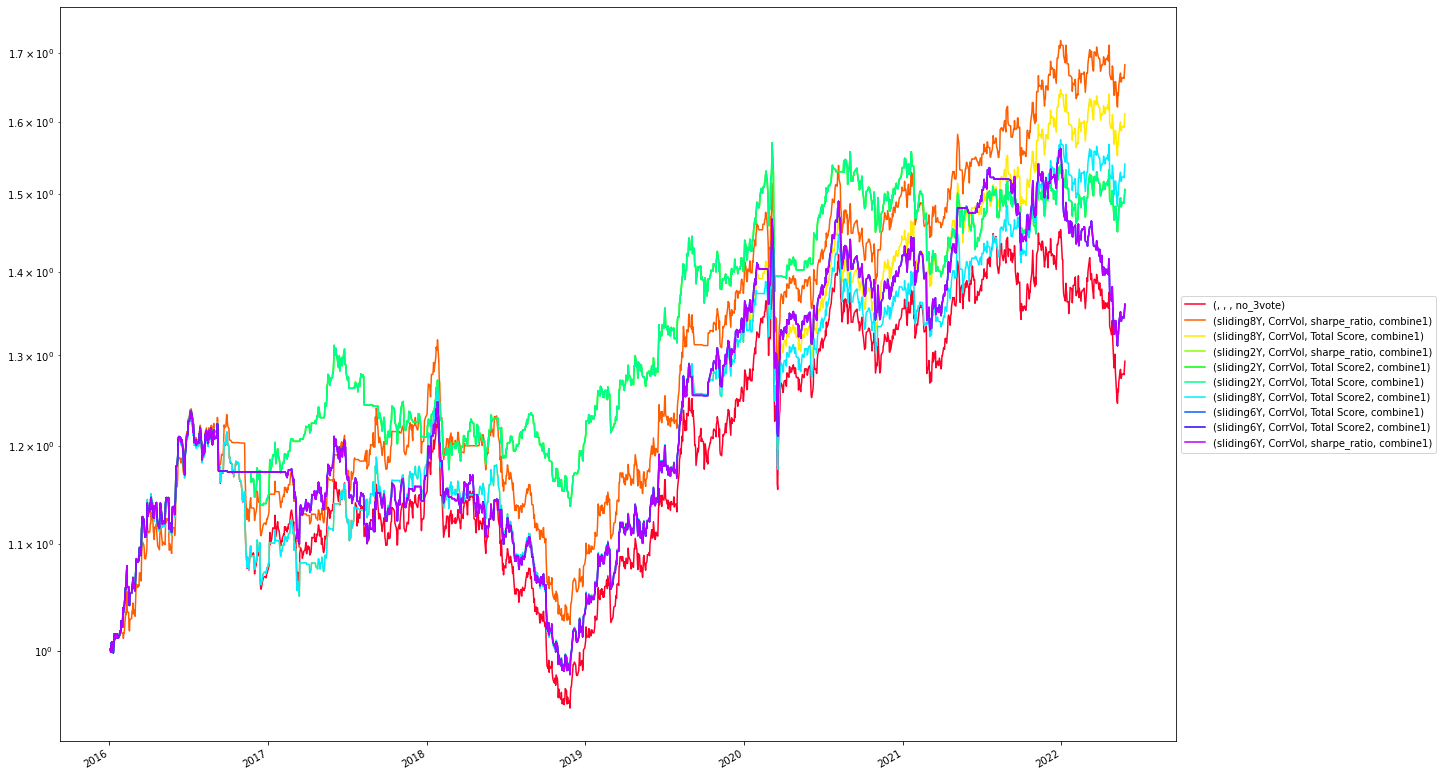

In [18]:
show_ret = pd.concat([base_case_ret, all_ret_df[show_df.index[1:10]]], axis=1)
show_ret = show_ret.dropna()
show_cum_ret(show_ret[start:])

In [21]:
groupby_items = [
    'sliding_year', 'case_pool', 'case_metrics', 'case_combine',
    ['sliding_year', 'case_pool'], ['sliding_year', 'case_combine']
]

all_met_df_count = all_met_df.loc[all_met_df.index.get_level_values('case_combine') != base_case_name, :]
show_df_count = show_df = sort_df[sort_df[sort_by] > base_case_met[sort_by].values[0]]
base_met_single_index = base_case_met.copy()
base_met_single_index.index = [base_case_name]


for gb in groupby_items:
    print("================================================== ", gb)
    ser1 = show_df_count.groupby(gb).count().mean(axis=1)
    ser2 = all_met_df_count.groupby(gb).count().mean(axis=1)
    ser3 = ser1 / ser2
    df = pd.concat([ser1.to_frame(), ser2.to_frame(), ser3.to_frame()], axis=1)
    df.columns = ['better', 'total', 'pct']
    display(df)

    perf = all_met_df_count.groupby(gb).mean()
    perf = pd.concat([base_met_single_index, perf])
    display(perf)

    perf_std = all_met_df_count.groupby(gb).std()
    display(perf_std)

==================================================  sliding_year


,better,total,pct
sliding_year,,,
sliding2Y,3.0,3.0,1.0
performanceSlidingYearExclude1&2Y,NaN,3.0,NaN
performanceSlidingYearInclude3-10Y,NaN,3.0,NaN
performanceSlidingYearInclude3-8Y,NaN,3.0,NaN
performanceSlidingYearInclude5-10Y,NaN,3.0,NaN
performanceSlidingYearInclude5-8Y,NaN,3.0,NaN
sliding10Y,NaN,3.0,NaN
sliding1Y,NaN,3.0,NaN
sliding3Y,NaN,3.0,NaN


,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
no_3vote,9.175958,0.092493,0.783879,0.122444,-0.299392,-0.074685,0.308936,1.238445,78.387882,104.624651,70.060753,92.531520,2.884897,2.511473,0.988501,0.022700
performanceSlidingYearExclude1&2Y,4.177639,0.064652,0.606654,0.113984,-0.326255,-0.093759,0.198232,0.692814,60.665385,103.232589,67.374519,90.624098,1.725254,1.256459,0.918949,0.053269
performanceSlidingYearInclude3-10Y,3.355557,0.057611,0.549254,0.113735,-0.438067,-0.133433,0.131709,0.431995,54.925356,102.880569,56.193318,86.656740,0.843991,0.176828,0.905785,0.056094
performanceSlidingYearInclude3-8Y,4.318731,0.065720,0.610936,0.115019,-0.341271,-0.102484,0.192904,0.641209,61.093567,103.286018,65.872888,89.751554,1.676924,1.164502,0.919504,0.052966
performanceSlidingYearInclude5-10Y,3.005475,0.054324,0.522075,0.113734,-0.400124,-0.115247,0.135768,0.472189,52.207502,102.716198,59.987647,88.475328,0.881377,0.305144,0.897665,0.055791
performanceSlidingYearInclude5-8Y,4.435287,0.066675,0.620406,0.114655,-0.262476,-0.075758,0.254092,0.881109,62.040580,103.333729,73.752448,92.424233,2.123024,1.744236,0.906996,0.054984
sliding10Y,4.514733,0.067269,0.631213,0.113338,-0.445366,-0.125837,0.151049,0.534624,63.121348,103.363470,55.463392,87.416312,1.265584,0.636400,0.905583,0.051755
sliding1Y,2.307946,0.046645,0.489521,0.104277,-0.381889,-0.119081,0.122142,0.391752,48.952061,102.332234,61.811090,88.091851,0.771381,0.175974,0.794422,0.077482
sliding2Y,7.670914,0.085845,0.827289,0.106427,-0.282242,-0.064507,0.304153,1.331624,82.728933,104.292233,71.775807,93.549350,3.154460,2.831928,0.847430,0.081114
sliding3Y,2.835493,0.052593,0.510617,0.112882,-0.373264,-0.115779,0.140992,0.454424,51.061714,102.629637,62.673619,88.422121,0.949730,0.370836,0.916024,0.056396


,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
sliding_year,,,,,,,,,,,,,,,,
performanceSlidingYearExclude1&2Y,0.330399,0.002635,0.018937,0.000708,1.642764e-02,0.009744,0.002333,0.047251,1.893725,0.131771,1.642764e+00,0.974383,0.031255,0.032742,0.007519,0.002402
performanceSlidingYearInclude3-10Y,0.377208,0.003537,0.024406,0.001455,1.737388e-02,0.005311,0.010931,0.027135,2.440639,0.176840,1.737388e+00,0.531076,0.177078,0.181984,0.022654,0.002538
performanceSlidingYearInclude3-8Y,0.404434,0.003161,0.023830,0.000474,1.105471e-02,0.000331,0.015227,0.028828,2.383035,0.158067,1.105471e+00,0.033138,0.190232,0.188575,0.004979,0.002097
performanceSlidingYearInclude5-10Y,0.123831,0.001233,0.009036,0.000342,7.130536e-16,0.004647,0.003080,0.030443,0.903638,0.061628,6.665482e-14,0.464697,0.051345,0.074579,0.011444,0.000874
performanceSlidingYearInclude5-8Y,0.104675,0.000779,0.004968,0.000317,7.124450e-03,0.002691,0.003868,0.042449,0.496765,0.038959,7.124450e-01,0.269057,0.006888,0.006565,0.010570,0.000349
sliding10Y,0.028365,0.000209,0.002163,0.000095,2.852708e-03,0.001264,0.001442,0.007072,0.216334,0.010451,2.852708e-01,0.126395,0.026125,0.032445,0.000000,0.000000
sliding1Y,0.153527,0.001848,0.019841,0.000783,0.000000e+00,0.000560,0.004838,0.017144,1.984128,0.092387,0.000000e+00,0.056048,0.108445,0.110904,0.008714,0.000151
sliding2Y,0.087970,0.000419,0.008461,0.001262,2.857611e-16,0.001984,0.001486,0.041080,0.846080,0.020968,2.009718e-14,0.198399,0.042718,0.052047,0.019612,0.004194
sliding3Y,0.041655,0.000437,0.002315,0.000389,1.326105e-02,0.003256,0.003918,0.009152,0.231462,0.021861,1.326105e+00,0.325604,0.052546,0.068826,0.004455,0.001223


==================================================  case_pool


,better,total,pct
case_pool,,,
CorrVol,3.0,45.0,0.066667


,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
no_3vote,9.175958,0.092493,0.783879,0.122444,-0.299392,-0.074685,0.308936,1.238445,78.387882,104.624651,70.060753,92.531520,2.884897,2.511473,0.988501,0.022700
CorrVol,4.592465,0.066509,0.627891,0.112574,-0.333258,-0.094242,0.209082,0.764316,62.789145,103.325474,66.674213,90.575752,1.805715,1.334503,0.895422,0.057372


,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
case_pool,,,,,,,,,,,,,,,,
CorrVol,1.478755,0.010757,0.089921,0.003173,0.062445,0.022552,0.059039,0.270675,8.992138,0.537847,6.244516,2.255161,0.711234,0.814417,0.036863,0.008963


==================================================  case_metrics


,better,total,pct
case_metrics,,,
Total Score,1.0,15.0,0.066667
Total Score2,1.0,15.0,0.066667
sharpe_ratio,1.0,15.0,0.066667


,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
no_3vote,9.175958,0.092493,0.783879,0.122444,-0.299392,-0.074685,0.308936,1.238445,78.387882,104.624651,70.060753,92.531520,2.884897,2.511473,0.988501,0.022700
Total Score,4.624188,0.066710,0.629194,0.112625,-0.335537,-0.095783,0.208338,0.755159,62.919360,103.335517,66.446275,90.421718,1.801833,1.322919,0.895012,0.056911
Total Score2,4.616788,0.066847,0.630360,0.112672,-0.331243,-0.095358,0.211915,0.756864,63.036027,103.342362,66.875668,90.464158,1.829821,1.353029,0.895889,0.057163
sharpe_ratio,4.536419,0.065971,0.624120,0.112424,-0.332993,-0.091586,0.206994,0.780925,62.412049,103.298545,66.700697,90.841380,1.785492,1.327561,0.895365,0.058041


,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
case_metrics,,,,,,,,,,,,,,,,
Total Score,1.545900,0.011112,0.092033,0.003067,0.065244,0.023631,0.060055,0.276571,9.203293,0.555608,6.524439,2.363145,0.735851,0.844528,0.035528,0.008780
Total Score2,1.427270,0.010316,0.086015,0.003358,0.064868,0.022642,0.061271,0.269523,8.601509,0.515780,6.486805,2.264226,0.700611,0.806747,0.039228,0.008647
sharpe_ratio,1.562227,0.011545,0.097573,0.003305,0.061486,0.022712,0.059834,0.284045,9.757279,0.577273,6.148630,2.271181,0.745933,0.848496,0.038330,0.009992


==================================================  case_combine


,better,total,pct
case_combine,,,
combine1,3.0,45.0,0.066667


,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
no_3vote,9.175958,0.092493,0.783879,0.122444,-0.299392,-0.074685,0.308936,1.238445,78.387882,104.624651,70.060753,92.531520,2.884897,2.511473,0.988501,0.022700
combine1,4.592465,0.066509,0.627891,0.112574,-0.333258,-0.094242,0.209082,0.764316,62.789145,103.325474,66.674213,90.575752,1.805715,1.334503,0.895422,0.057372


,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
case_combine,,,,,,,,,,,,,,,,
combine1,1.478755,0.010757,0.089921,0.003173,0.062445,0.022552,0.059039,0.270675,8.992138,0.537847,6.244516,2.255161,0.711234,0.814417,0.036863,0.008963


==================================================  ['sliding_year', 'case_pool']


,,better,total,pct
sliding_year,case_pool,,,
sliding2Y,CorrVol,3.0,3.0,1.0
performanceSlidingYearExclude1&2Y,CorrVol,NaN,3.0,NaN
performanceSlidingYearInclude3-10Y,CorrVol,NaN,3.0,NaN
performanceSlidingYearInclude3-8Y,CorrVol,NaN,3.0,NaN
performanceSlidingYearInclude5-10Y,CorrVol,NaN,3.0,NaN
performanceSlidingYearInclude5-8Y,CorrVol,NaN,3.0,NaN
sliding10Y,CorrVol,NaN,3.0,NaN
sliding1Y,CorrVol,NaN,3.0,NaN
sliding3Y,CorrVol,NaN,3.0,NaN


,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
no_3vote,9.175958,0.092493,0.783879,0.122444,-0.299392,-0.074685,0.308936,1.238445,78.387882,104.624651,70.060753,92.531520,2.884897,2.511473,0.988501,0.022700
"(performanceSlidingYearExclude1&2Y, CorrVol)",4.177639,0.064652,0.606654,0.113984,-0.326255,-0.093759,0.198232,0.692814,60.665385,103.232589,67.374519,90.624098,1.725254,1.256459,0.918949,0.053269
"(performanceSlidingYearInclude3-10Y, CorrVol)",3.355557,0.057611,0.549254,0.113735,-0.438067,-0.133433,0.131709,0.431995,54.925356,102.880569,56.193318,86.656740,0.843991,0.176828,0.905785,0.056094
"(performanceSlidingYearInclude3-8Y, CorrVol)",4.318731,0.065720,0.610936,0.115019,-0.341271,-0.102484,0.192904,0.641209,61.093567,103.286018,65.872888,89.751554,1.676924,1.164502,0.919504,0.052966
"(performanceSlidingYearInclude5-10Y, CorrVol)",3.005475,0.054324,0.522075,0.113734,-0.400124,-0.115247,0.135768,0.472189,52.207502,102.716198,59.987647,88.475328,0.881377,0.305144,0.897665,0.055791
"(performanceSlidingYearInclude5-8Y, CorrVol)",4.435287,0.066675,0.620406,0.114655,-0.262476,-0.075758,0.254092,0.881109,62.040580,103.333729,73.752448,92.424233,2.123024,1.744236,0.906996,0.054984
"(sliding10Y, CorrVol)",4.514733,0.067269,0.631213,0.113338,-0.445366,-0.125837,0.151049,0.534624,63.121348,103.363470,55.463392,87.416312,1.265584,0.636400,0.905583,0.051755
"(sliding1Y, CorrVol)",2.307946,0.046645,0.489521,0.104277,-0.381889,-0.119081,0.122142,0.391752,48.952061,102.332234,61.811090,88.091851,0.771381,0.175974,0.794422,0.077482
"(sliding2Y, CorrVol)",7.670914,0.085845,0.827289,0.106427,-0.282242,-0.064507,0.304153,1.331624,82.728933,104.292233,71.775807,93.549350,3.154460,2.831928,0.847430,0.081114
"(sliding3Y, CorrVol)",2.835493,0.052593,0.510617,0.112882,-0.373264,-0.115779,0.140992,0.454424,51.061714,102.629637,62.673619,88.422121,0.949730,0.370836,0.916024,0.056396


,,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
sliding_year,case_pool,,,,,,,,,,,,,,,,
performanceSlidingYearExclude1&2Y,CorrVol,0.330399,0.002635,0.018937,0.000708,1.642764e-02,0.009744,0.002333,0.047251,1.893725,0.131771,1.642764e+00,0.974383,0.031255,0.032742,0.007519,0.002402
performanceSlidingYearInclude3-10Y,CorrVol,0.377208,0.003537,0.024406,0.001455,1.737388e-02,0.005311,0.010931,0.027135,2.440639,0.176840,1.737388e+00,0.531076,0.177078,0.181984,0.022654,0.002538
performanceSlidingYearInclude3-8Y,CorrVol,0.404434,0.003161,0.023830,0.000474,1.105471e-02,0.000331,0.015227,0.028828,2.383035,0.158067,1.105471e+00,0.033138,0.190232,0.188575,0.004979,0.002097
performanceSlidingYearInclude5-10Y,CorrVol,0.123831,0.001233,0.009036,0.000342,7.130536e-16,0.004647,0.003080,0.030443,0.903638,0.061628,6.665482e-14,0.464697,0.051345,0.074579,0.011444,0.000874
performanceSlidingYearInclude5-8Y,CorrVol,0.104675,0.000779,0.004968,0.000317,7.124450e-03,0.002691,0.003868,0.042449,0.496765,0.038959,7.124450e-01,0.269057,0.006888,0.006565,0.010570,0.000349
sliding10Y,CorrVol,0.028365,0.000209,0.002163,0.000095,2.852708e-03,0.001264,0.001442,0.007072,0.216334,0.010451,2.852708e-01,0.126395,0.026125,0.032445,0.000000,0.000000
sliding1Y,CorrVol,0.153527,0.001848,0.019841,0.000783,0.000000e+00,0.000560,0.004838,0.017144,1.984128,0.092387,0.000000e+00,0.056048,0.108445,0.110904,0.008714,0.000151
sliding2Y,CorrVol,0.087970,0.000419,0.008461,0.001262,2.857611e-16,0.001984,0.001486,0.041080,0.846080,0.020968,2.009718e-14,0.198399,0.042718,0.052047,0.019612,0.004194
sliding3Y,CorrVol,0.041655,0.000437,0.002315,0.000389,1.326105e-02,0.003256,0.003918,0.009152,0.231462,0.021861,1.326105e+00,0.325604,0.052546,0.068826,0.004455,0.001223


==================================================  ['sliding_year', 'case_combine']


,,better,total,pct
sliding_year,case_combine,,,
sliding2Y,combine1,3.0,3.0,1.0
performanceSlidingYearExclude1&2Y,combine1,NaN,3.0,NaN
performanceSlidingYearInclude3-10Y,combine1,NaN,3.0,NaN
performanceSlidingYearInclude3-8Y,combine1,NaN,3.0,NaN
performanceSlidingYearInclude5-10Y,combine1,NaN,3.0,NaN
performanceSlidingYearInclude5-8Y,combine1,NaN,3.0,NaN
sliding10Y,combine1,NaN,3.0,NaN
sliding1Y,combine1,NaN,3.0,NaN
sliding3Y,combine1,NaN,3.0,NaN


,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
no_3vote,9.175958,0.092493,0.783879,0.122444,-0.299392,-0.074685,0.308936,1.238445,78.387882,104.624651,70.060753,92.531520,2.884897,2.511473,0.988501,0.022700
"(performanceSlidingYearExclude1&2Y, combine1)",4.177639,0.064652,0.606654,0.113984,-0.326255,-0.093759,0.198232,0.692814,60.665385,103.232589,67.374519,90.624098,1.725254,1.256459,0.918949,0.053269
"(performanceSlidingYearInclude3-10Y, combine1)",3.355557,0.057611,0.549254,0.113735,-0.438067,-0.133433,0.131709,0.431995,54.925356,102.880569,56.193318,86.656740,0.843991,0.176828,0.905785,0.056094
"(performanceSlidingYearInclude3-8Y, combine1)",4.318731,0.065720,0.610936,0.115019,-0.341271,-0.102484,0.192904,0.641209,61.093567,103.286018,65.872888,89.751554,1.676924,1.164502,0.919504,0.052966
"(performanceSlidingYearInclude5-10Y, combine1)",3.005475,0.054324,0.522075,0.113734,-0.400124,-0.115247,0.135768,0.472189,52.207502,102.716198,59.987647,88.475328,0.881377,0.305144,0.897665,0.055791
"(performanceSlidingYearInclude5-8Y, combine1)",4.435287,0.066675,0.620406,0.114655,-0.262476,-0.075758,0.254092,0.881109,62.040580,103.333729,73.752448,92.424233,2.123024,1.744236,0.906996,0.054984
"(sliding10Y, combine1)",4.514733,0.067269,0.631213,0.113338,-0.445366,-0.125837,0.151049,0.534624,63.121348,103.363470,55.463392,87.416312,1.265584,0.636400,0.905583,0.051755
"(sliding1Y, combine1)",2.307946,0.046645,0.489521,0.104277,-0.381889,-0.119081,0.122142,0.391752,48.952061,102.332234,61.811090,88.091851,0.771381,0.175974,0.794422,0.077482
"(sliding2Y, combine1)",7.670914,0.085845,0.827289,0.106427,-0.282242,-0.064507,0.304153,1.331624,82.728933,104.292233,71.775807,93.549350,3.154460,2.831928,0.847430,0.081114
"(sliding3Y, combine1)",2.835493,0.052593,0.510617,0.112882,-0.373264,-0.115779,0.140992,0.454424,51.061714,102.629637,62.673619,88.422121,0.949730,0.370836,0.916024,0.056396


,,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd,Sharpe Score,Return Score,Max-DD Score,Avg-DD Score,Total Score,Total Score2,buy_ratio,flip_ratio
sliding_year,case_combine,,,,,,,,,,,,,,,,
performanceSlidingYearExclude1&2Y,combine1,0.330399,0.002635,0.018937,0.000708,1.642764e-02,0.009744,0.002333,0.047251,1.893725,0.131771,1.642764e+00,0.974383,0.031255,0.032742,0.007519,0.002402
performanceSlidingYearInclude3-10Y,combine1,0.377208,0.003537,0.024406,0.001455,1.737388e-02,0.005311,0.010931,0.027135,2.440639,0.176840,1.737388e+00,0.531076,0.177078,0.181984,0.022654,0.002538
performanceSlidingYearInclude3-8Y,combine1,0.404434,0.003161,0.023830,0.000474,1.105471e-02,0.000331,0.015227,0.028828,2.383035,0.158067,1.105471e+00,0.033138,0.190232,0.188575,0.004979,0.002097
performanceSlidingYearInclude5-10Y,combine1,0.123831,0.001233,0.009036,0.000342,7.130536e-16,0.004647,0.003080,0.030443,0.903638,0.061628,6.665482e-14,0.464697,0.051345,0.074579,0.011444,0.000874
performanceSlidingYearInclude5-8Y,combine1,0.104675,0.000779,0.004968,0.000317,7.124450e-03,0.002691,0.003868,0.042449,0.496765,0.038959,7.124450e-01,0.269057,0.006888,0.006565,0.010570,0.000349
sliding10Y,combine1,0.028365,0.000209,0.002163,0.000095,2.852708e-03,0.001264,0.001442,0.007072,0.216334,0.010451,2.852708e-01,0.126395,0.026125,0.032445,0.000000,0.000000
sliding1Y,combine1,0.153527,0.001848,0.019841,0.000783,0.000000e+00,0.000560,0.004838,0.017144,1.984128,0.092387,0.000000e+00,0.056048,0.108445,0.110904,0.008714,0.000151
sliding2Y,combine1,0.087970,0.000419,0.008461,0.001262,2.857611e-16,0.001984,0.001486,0.041080,0.846080,0.020968,2.009718e-14,0.198399,0.042718,0.052047,0.019612,0.004194
sliding3Y,combine1,0.041655,0.000437,0.002315,0.000389,1.326105e-02,0.003256,0.003918,0.009152,0.231462,0.021861,1.326105e+00,0.325604,0.052546,0.068826,0.004455,0.001223
